In [1]:
#base on arXiv:1910.14030
import numpy as np
from numpy.linalg import norm
from qiskit import(
  QuantumCircuit,
  execute,
  Aer)
from qiskit.aqua.operator import Operator
from qiskit.quantum_info import Pauli
from qiskit.assembler.run_config import RunConfig
from qiskit.providers.aer import noise
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit, execute, Aer, IBMQ
import json
from qiskit.visualization.circuit_visualization import circuit_drawer
import sympy
import scipy as sp

In [2]:
#read the configuration of hamiltonians calculated by OpenFermion
thetas=np.loadtxt("thetas.txt")
nn_input=np.loadtxt("hamiltonians.txt")
bond_distance=nn_input[:,0].astype('float64')
config_Hs=nn_input[:,1:].astype('float64')
gs_energies=np.loadtxt('gs_energy.txt')
paulis_list=['II','IZ','ZI','ZZ','XX','YY']
# order of qubits is different from projectQ
n_samples,n_features=config_Hs.shape

In [3]:
#showing the distances we calculate
n_samples, bond_distance

(54, array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
        0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25,
        1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 ,
        1.85, 1.9 , 1.95, 2.  , 2.05, 2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35,
        2.4 , 2.45, 2.5 , 2.55, 2.6 , 2.65, 2.7 , 2.75, 2.8 , 2.85]))

In [4]:
#we use Aer as backend
simulator=Aer.get_backend('statevector_simulator')
nq,nc=2,2

In [5]:
def alpha_term(length,less1,less2,more1,more2,bc = 'OBC'):
        #stretch

        res = np.zeros((length, length))
        range_ = range(1, length - 1) if bc == 'OBC' else range(length)
        for i in range_:
            res[i, i] += 2.
            res[i, less1[i]] += -1.
            res[i, more1[i]] += -1.
        return res

def beta_term(length,less1,less2,more1,more2,bc = 'OBC'):
    #bending

    res = np.zeros((length, length))
    range_ = range(1, length - 1) if bc == 'OBC' else range(length)
    for i in range_:
        res[i, i] += 6.
        # nn
        res[i, less1[i]] += -4.
        res[i, more1[i]] += -4.
        # nnn left
        if bc == 'OBC' and i == 1:
            # mirror-point method
            res[1, 0] += 2.
            res[1, 1] -= 1.
        else:
            res[i, less2[i]] += +1.
        # nnn right
        if bc == 'OBC' and i == length - 2:
            # mirror-point method
            res[length - 2, length - 1] += 2.
            res[length - 2, length - 2] -= 1.
        else:
            res[i, more2[i]] += +1.
    return res

def snake_matrix(alpha,beta,gamma,bc='OBC'):
    #the matrix A that describe the snake
    id_ = np.arange(n_samples)
    less1 = np.roll(id_, +1)
    less2 = np.roll(id_, +2)
    more1 = np.roll(id_, -1)
    more2 = np.roll(id_, -2)
    length=n_samples
    # implicit time-evolution matrix as in Kass
    A = alpha * alpha_term(length,less1,less2,more1,more2,bc = bc) + beta * beta_term(length,less1,less2,more1,more2,bc = bc)
    inversion_A = np.linalg.inv(A + gamma * np.identity(length))
    return inversion_A

In [6]:
sigz=np.array([[1,0],[0,-1]])
sigy=np.array([[0,-1j],[1j,0]])
sigx=np.array([[0,1],[1,0]])
sig0=np.array([[1,0],[0,1]])

def ham(config_H):
    #hamiltonian of H2 molecule
    hamiltonian = config_H[0] * np.kron(sig0,sig0)  # == identity
    hamiltonian = hamiltonian+config_H[1] * np.kron(sig0,sigz) 
    hamiltonian = hamiltonian+config_H[2] * np.kron(sigz,sig0) 
    hamiltonian =hamiltonian+ config_H[3] * np.kron(sigz,sigz)
    hamiltonian =hamiltonian+ config_H[4] * np.kron(sigx,sigx)
    hamiltonian =hamiltonian+ config_H[5] * np.real(np.kron(sigy,sigy)).astype('float64')
    #return torch.from_numpy(hamiltonian).type(dtype)
    return hamiltonian

In [7]:
def circuit_ansatz(theta):
    #UCC ansatz
    circuit=QuantumCircuit(nq)
    circuit.x(0)
    circuit.rx(-np.pi/2,0)
    circuit.ry(np.pi/2,1)
    circuit.cx(1,0)
    circuit.rz(theta,0)
    circuit.cx(1,0)
    circuit.rx(np.pi/2,0)
    circuit.ry(-np.pi/2,1)
    return circuit


def energy_H_matrix(theta,config_H,backend=simulator):
    #run the circuit
    circuit=circuit_ansatz(theta)
    hamiltonian=ham(config_H)
    eval_circuit=Operator(matrix=hamiltonian)
    eval_circuit.construct_evaluation_circuit(operator_mode='matrix',input_circuit=circuit,backend=backend)
    return np.real(eval_circuit.eval(operator_mode='matrix',input_circuit=circuit,backend=backend))[0]

def energies(thetas,config_Hs):
    #storing the result
    es=[]
    for i in range(thetas.shape[0]):
        es.append(energy_H_matrix(thetas[i],config_Hs[i,:]))
    return np.array(es)

In [8]:
def grad(theta,config_H):
    #calculate the gradient decent of the snake+molecule energy
    dtheta=np.pi/2
    grad=(energy_H_matrix(theta+dtheta,config_H)-energy_H_matrix(theta-dtheta,config_H))/2
    return grad


def grads(thetas,config_Hs,bc='OBC'):
    gs=[]
    for i in range(thetas.shape[0]):
        gs.append(grad(thetas[i],config_Hs[i,:]))
    gs=np.array(gs)
    return np.array(gs)
    

def training(config_Hs,decay_rate=0.1,learning_rate=1,snake_paras=[0.1,3,2],t_steps=30,stop_e=1e-4):
    #minimizing the energy of the system by gradient decent
    thetas=np.random.rand(n_samples)
    gamma=snake_paras[2]
    thetas_history=[thetas]
    for i in range(t_steps):    
        decay=np.exp(-i*decay_rate)
        alpha=snake_paras[0]*decay
        beta=snake_paras[1]*decay
        inv_A=snake_matrix(alpha,beta,gamma)
        thetas=np.dot(inv_A, gamma*thetas-learning_rate*grads(thetas,config_Hs))
        thetas=np.clip(thetas,0,2*np.pi)
        if (i+1)%5==0:
            thetas_history.append(thetas)
            print(thetas[[1,10,20,30,40,-1]])
    return thetas_history

In [10]:
import timeit
#timing the training process
start_time = timeit.default_timer()
thetas_history=training(config_Hs)
elapsed = timeit.default_timer() - start_time

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

[0.08716772 0.23434983 0.48042903 0.83754109 0.88888834 1.05313928]


/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

[0.0870929  0.21160846 0.48442602 0.86861107 1.0824585  1.27920861]


/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

[0.08704293 0.20994796 0.48549543 0.88590161 1.1725292  1.38300456]


/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

[0.08700318 0.20980605 0.48583472 0.89418068 1.21446964 1.42975678]


/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

[0.08697286 0.20977954 0.4859225  0.89796306 1.23399898 1.45073194]


/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:920: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:689: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

[0.08695046 0.20976432 0.48592958 0.89965569 1.24310022 1.46013482]


/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:267: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:793: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:369: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/site-packages/qiskit/aqua/operator.py:62: DeprecationWarning: The `Operator` class is deprecated and will be removed after 0.6. Use the class for each representation instead, including `MatrixOperator`, `WeightedPauliOperator` and `TPBGroupedWeightedPauliOperator`
  DeprecationWarning)
/anaconda3/envs/ibm/lib/python3.7/s

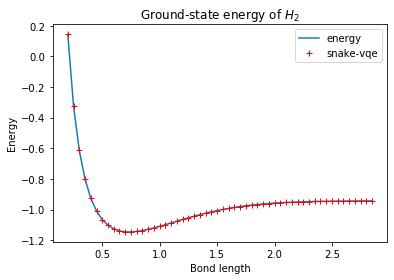

In [20]:
import matplotlib.pyplot as plt
#plot energy vs distance
fig = plt.figure()
plt.xlabel("Bond length")
plt.ylabel("Energy")
plt.title("Ground-state energy of $H_2$")
plt.plot(bond_distance, gs_energies, "-",
         label="energy")
plt.plot(bond_distance, energies(thetas_history[-1],config_Hs), "r+",
         label="snake-vqe")
plt.legend()
plt.savefig("energy_H2.png",dpi=300)
plt.show()

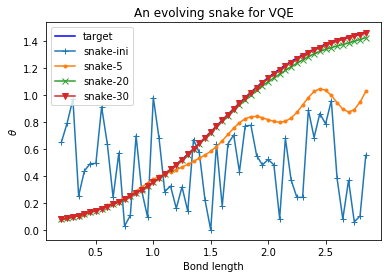

In [21]:
#plot the evolution of the snake
plt.xlabel("Bond length")
plt.ylabel("$\\theta$")
plt.title("An evolving snake for VQE")
plt.plot(bond_distance, thetas, "b-",
         label="target")
plt.plot(bond_distance, thetas_history[0], 
         "+-",label="snake-ini")
plt.plot(bond_distance, thetas_history[1], 
         ".-",label="snake-5")
plt.plot(bond_distance, thetas_history[4], 
         "x-",label="snake-20")
plt.plot(bond_distance, thetas_history[-1], "v-",
         label="snake-30")
plt.legend()
plt.savefig("evolving_snake_H2.png",dpi=300)
plt.show()

In [11]:
#show the time of training
elapsed

43.259281742999974